In [1]:
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 200
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-19 07:10:57.358132: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-19 07:10:57.374631: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa8b41ecba0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-19 07:10:57.374658: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [7]:
def calculate_term(e, c0, c1):
    a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
    b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
    return K.dot(K.transpose(a), b)

In [8]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
        p_loss += calculate_term(e, c0[i], c1[i])
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [9]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [10]:
print(len(c0))

28


In [11]:
model.add_loss(my_loss(i2, o, e, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [12]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(e, c0, c1):
    p_loss = []
    for i in range(len(c0)):
        p_loss.append(calculate_term(e, c0[i], c1[i]))
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(ps_term(e, c0, c1), name='ps', aggregation='mean')

In [13]:
history = model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_train_reshape)[limit:2*limit], y_train[limit:2*limit]], None),
                    batch_size=batch_size,
                    epochs=epochs)

Train on 4096 samples, validate on 4096 samples
Epoch 1/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 1.8278 - acc: 0.9215 - cce: 1.5420 - ps: 0.2858 - val_loss: 1.0303 - val_acc: 0.9567 - val_cce: 0.7535 - val_ps: 0.2768
Epoch 2/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.7492 - acc: 0.9722 - cce: 0.4923 - ps: 0.2570 - val_loss: 0.6187 - val_acc: 0.9797 - val_cce: 0.3883 - val_ps: 0.2304
Epoch 3/200
4096/4096 [==============================] - 29s 7ms/sample - loss: 0.5068 - acc: 0.9839 - cce: 0.3010 - ps: 0.2058 - val_loss: 0.4977 - val_acc: 0.9839 - val_cce: 0.3025 - val_ps: 0.1952
Epoch 4/200
4096/4096 [==============================] - 30s 7ms/sample - loss: 0.3986 - acc: 0.9880 - cce: 0.2187 - ps: 0.1799 - val_loss: 0.4360 - val_acc: 0.9857 - val_cce: 0.2702 - val_ps: 0.1659
Epoch 5/200
4096/4096 [==============================] - 29s 7ms/sample - loss: 0.3231 - acc: 0.9912 - cce: 0.1662 - ps: 0.1569 - val_loss: 0.4028 - val

4096/4096 [==============================] - 29s 7ms/sample - loss: 0.0480 - acc: 0.9996 - cce: 0.0064 - ps: 0.0416 - val_loss: 0.4053 - val_acc: 0.9857 - val_cce: 0.3583 - val_ps: 0.0470
Epoch 42/200
4096/4096 [==============================] - 29s 7ms/sample - loss: 0.0444 - acc: 0.9999 - cce: 0.0042 - ps: 0.0403 - val_loss: 0.4301 - val_acc: 0.9848 - val_cce: 0.3849 - val_ps: 0.0452
Epoch 43/200
4096/4096 [==============================] - 29s 7ms/sample - loss: 0.0474 - acc: 0.9998 - cce: 0.0050 - ps: 0.0424 - val_loss: 0.4319 - val_acc: 0.9846 - val_cce: 0.3850 - val_ps: 0.0469
Epoch 44/200
4096/4096 [==============================] - 29s 7ms/sample - loss: 0.0452 - acc: 0.9999 - cce: 0.0040 - ps: 0.0412 - val_loss: 0.4241 - val_acc: 0.9855 - val_cce: 0.3797 - val_ps: 0.0445
Epoch 45/200
4096/4096 [==============================] - 29s 7ms/sample - loss: 0.0409 - acc: 0.9998 - cce: 0.0038 - ps: 0.0372 - val_loss: 0.4333 - val_acc: 0.9854 - val_cce: 0.3892 - val_ps: 0.0441
Epoch 46

Epoch 82/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0338 - acc: 0.9998 - cce: 0.0024 - ps: 0.0314 - val_loss: 0.5327 - val_acc: 0.9836 - val_cce: 0.4975 - val_ps: 0.0351
Epoch 83/200
4096/4096 [==============================] - 27s 7ms/sample - loss: 0.0337 - acc: 0.9999 - cce: 0.0028 - ps: 0.0309 - val_loss: 0.5157 - val_acc: 0.9840 - val_cce: 0.4798 - val_ps: 0.0359
Epoch 84/200
4096/4096 [==============================] - 27s 7ms/sample - loss: 0.0359 - acc: 0.9997 - cce: 0.0046 - ps: 0.0312 - val_loss: 0.5376 - val_acc: 0.9833 - val_cce: 0.5023 - val_ps: 0.0353
Epoch 85/200
4096/4096 [==============================] - 27s 7ms/sample - loss: 0.0323 - acc: 0.9999 - cce: 0.0022 - ps: 0.0301 - val_loss: 0.5408 - val_acc: 0.9835 - val_cce: 0.5055 - val_ps: 0.0353
Epoch 86/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0347 - acc: 0.9998 - cce: 0.0023 - ps: 0.0324 - val_loss: 0.5289 - val_acc: 0.9837 - val_cce: 0.4935 - val_ps: 0.

Epoch 123/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0324 - acc: 0.9999 - cce: 0.0017 - ps: 0.0306 - val_loss: 0.7267 - val_acc: 0.9788 - val_cce: 0.6915 - val_ps: 0.0351
Epoch 124/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0321 - acc: 0.9998 - cce: 0.0031 - ps: 0.0290 - val_loss: 0.6838 - val_acc: 0.9813 - val_cce: 0.6485 - val_ps: 0.0353
Epoch 125/200
4096/4096 [==============================] - 29s 7ms/sample - loss: 0.0323 - acc: 0.9998 - cce: 0.0026 - ps: 0.0296 - val_loss: 0.6796 - val_acc: 0.9793 - val_cce: 0.6463 - val_ps: 0.0333
Epoch 126/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0304 - acc: 0.9999 - cce: 0.0019 - ps: 0.0285 - val_loss: 0.6733 - val_acc: 0.9791 - val_cce: 0.6419 - val_ps: 0.0314
Epoch 127/200
4096/4096 [==============================] - 27s 7ms/sample - loss: 0.0342 - acc: 0.9998 - cce: 0.0028 - ps: 0.0315 - val_loss: 0.6402 - val_acc: 0.9808 - val_cce: 0.6075 - val_p

4096/4096 [==============================] - 25s 6ms/sample - loss: 0.0306 - acc: 0.9999 - cce: 0.0012 - ps: 0.0294 - val_loss: 0.7528 - val_acc: 0.9770 - val_cce: 0.7220 - val_ps: 0.0308
Epoch 164/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0279 - acc: 0.9999 - cce: 0.0024 - ps: 0.0255 - val_loss: 0.7453 - val_acc: 0.9790 - val_cce: 0.7129 - val_ps: 0.0323
Epoch 165/200
4096/4096 [==============================] - 28s 7ms/sample - loss: 0.0337 - acc: 0.9998 - cce: 0.0040 - ps: 0.0297 - val_loss: 0.7299 - val_acc: 0.9803 - val_cce: 0.6969 - val_ps: 0.0329
Epoch 166/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0300 - acc: 0.9999 - cce: 0.0013 - ps: 0.0287 - val_loss: 0.7368 - val_acc: 0.9780 - val_cce: 0.7055 - val_ps: 0.0313
Epoch 167/200
4096/4096 [==============================] - 26s 6ms/sample - loss: 0.0307 - acc: 0.9999 - cce: 0.0020 - ps: 0.0287 - val_loss: 0.7667 - val_acc: 0.9784 - val_cce: 0.7350 - val_ps: 0.0317
Epoc

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


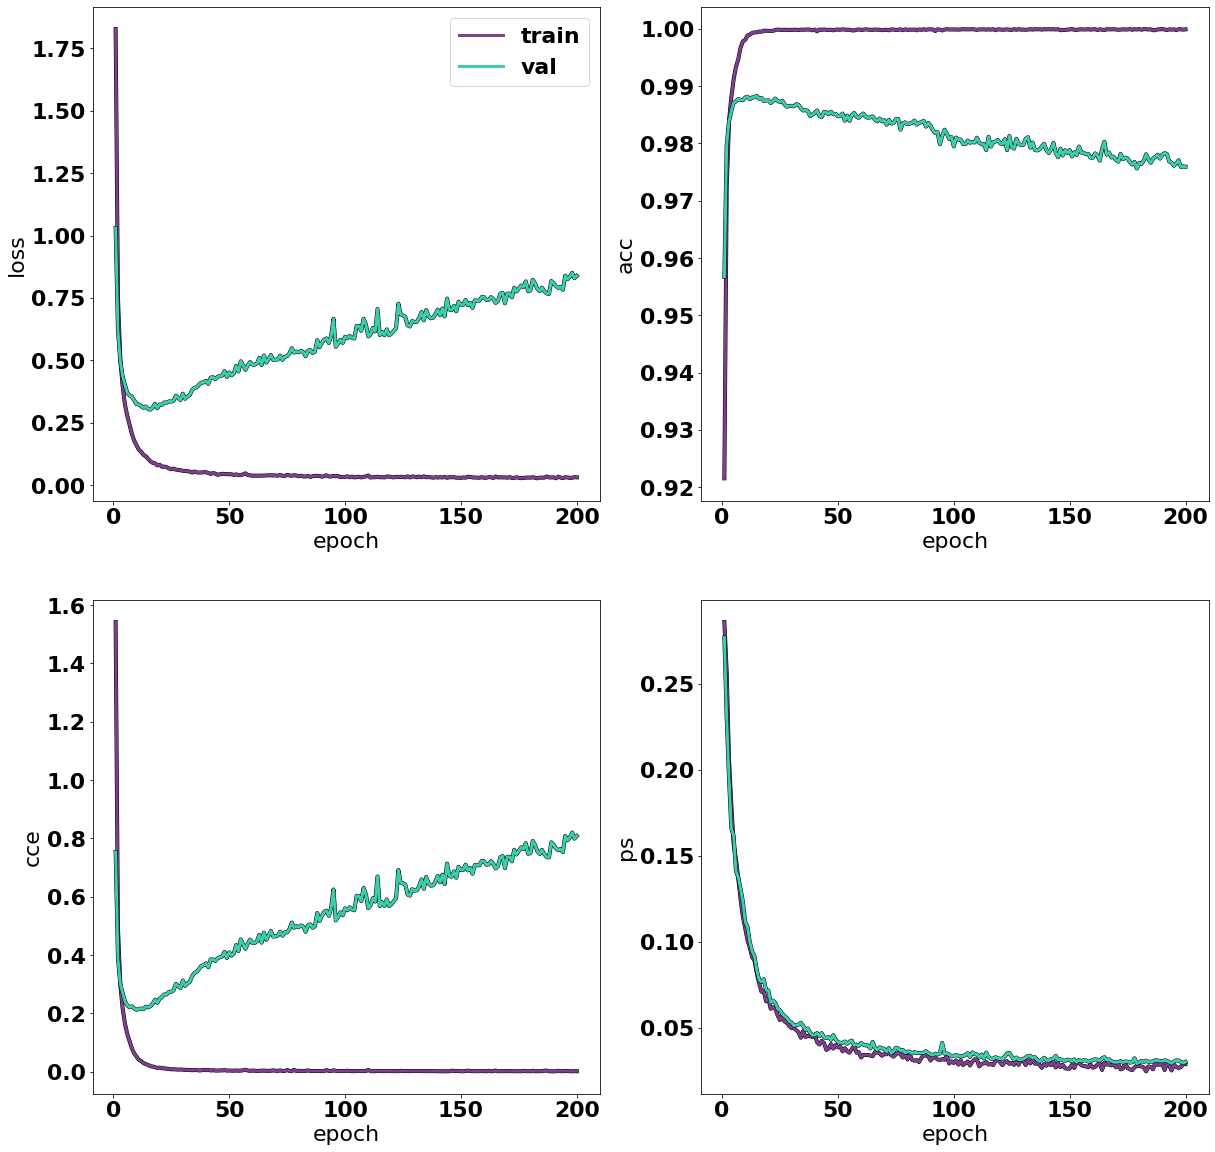

In [14]:
fig = plt.figure(figsize=(20,20))
for j,m in enumerate(['loss', 'acc', 'cce', 'ps']):
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])


### calculate test set accuracy

In [15]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.97463


### calculate activations across the training set

In [16]:
embed = tf.keras.Model(inputs=i, outputs=e)

In [17]:
embed.layers[1].set_weights(model.layers[1].get_weights())
activations_by_class = {}
a = embed.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 955.64it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


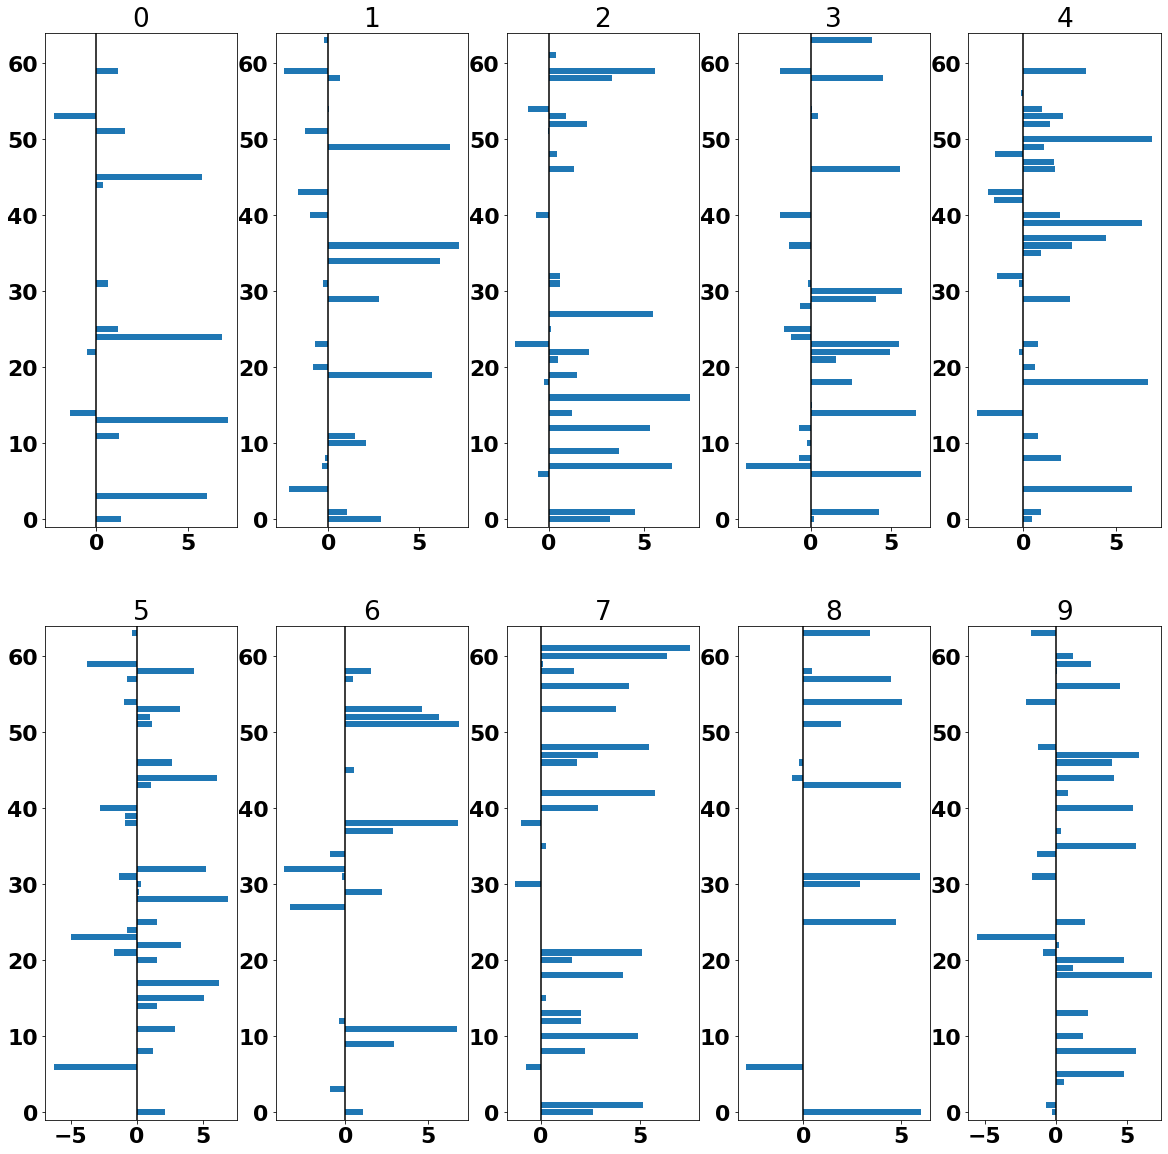

In [18]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### calculate activations across the test set

In [19]:
activations_by_class_test = {}
a = embed.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5889.31it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


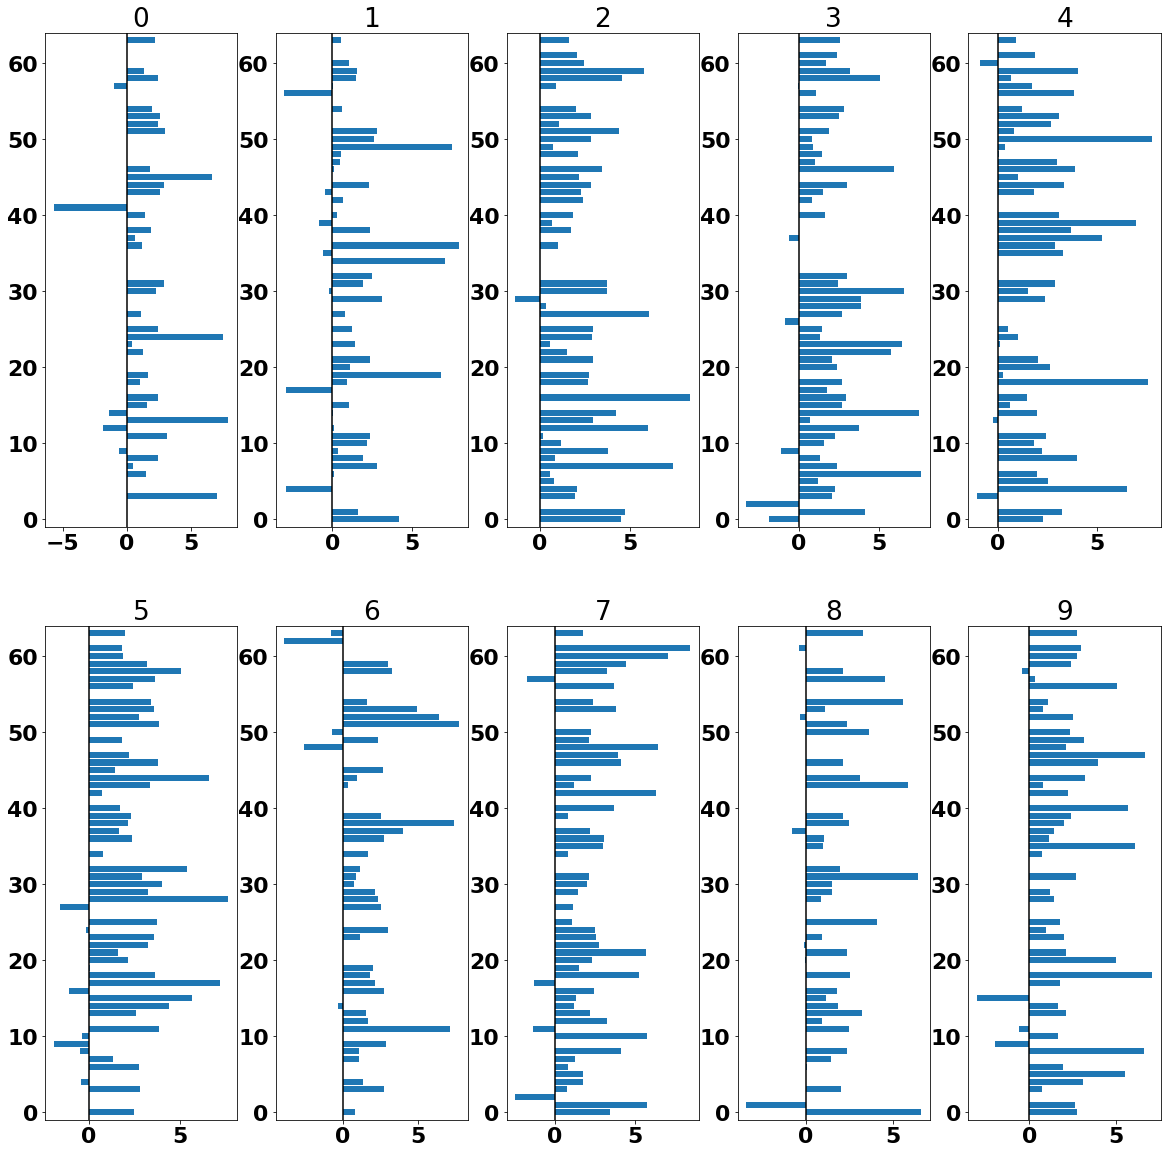

In [20]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [21]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.02683812548380552


### measure degree of polysemantism across test set activations

In [22]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.04353779981740647


### visualise hidden neurons

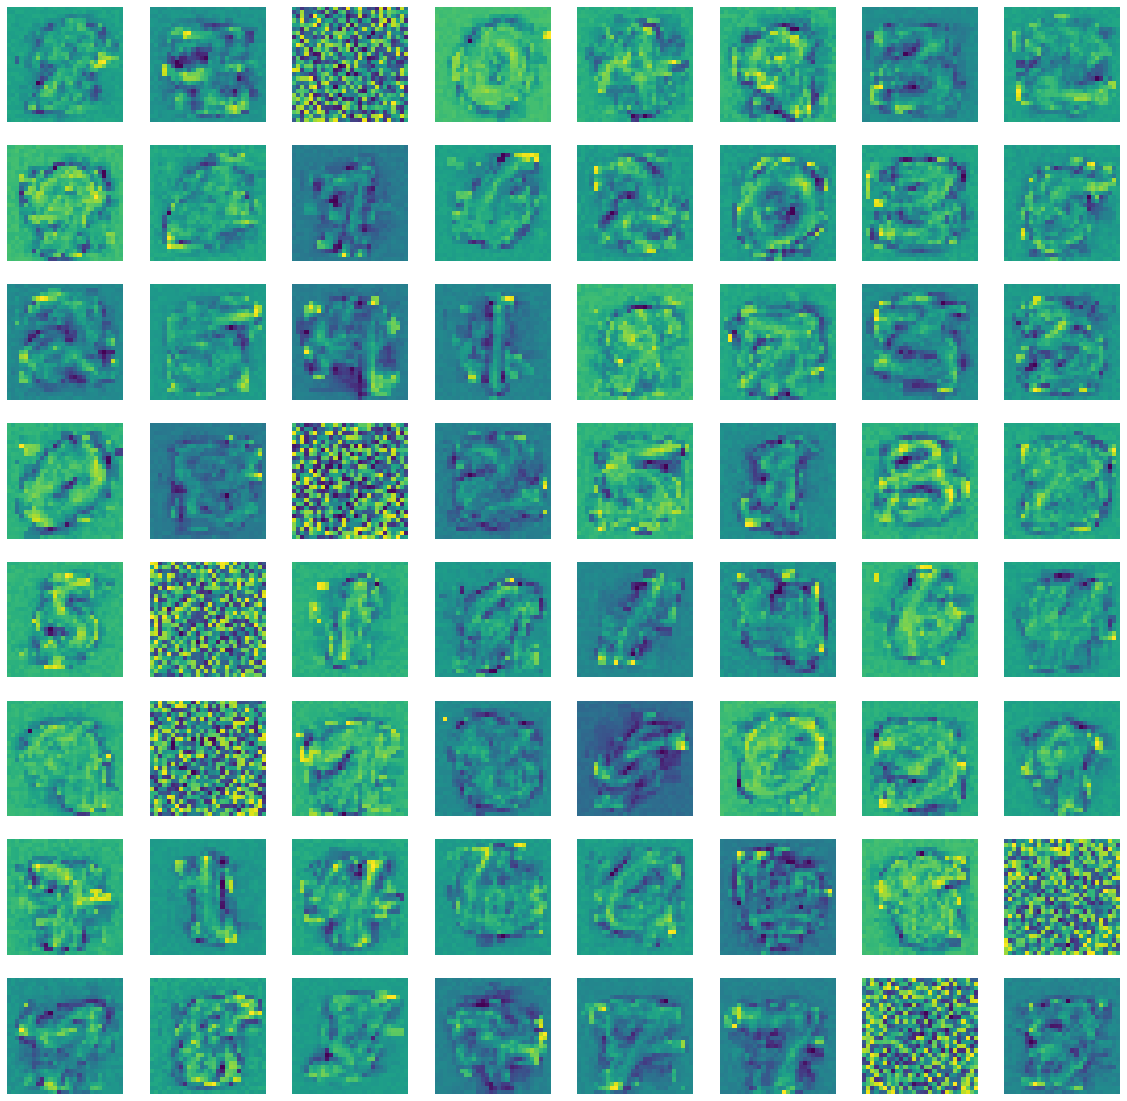

In [23]:
W = embed.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((28,28)))
    plt.axis('off')
plt.show()